# Active Learning  and SLIC Super Pixels.

## Introduction: 

In this notebook SLIC superpixels [2] together with several descriptors and Active Learning  techniques [1] will be applied over a known Horse Dataset[3]. We  follow the work of [4], first we extract Super Pixels regions, then we build a dataset using different filters over the images and gather togheter for each individual region first order statistics; subsequently we used Active Learning to build a model for image segmentation. Finally, we compare the performance of different estrategies such as random sampling and uncertainty sampling, using f-score and error functions. 

## SLIC Super Pixels: 

SLIC (Simple Linear Iterative Clustering) is an algorithm to cluster pixels combining five-dimensional color and image plane space to efficiently generate compact, nearly uniform superpixels. One of its best features is the low-cost / high quality segmentation it has [5]. Here is some code following [6] and [7] applyied to our particular dataset. 

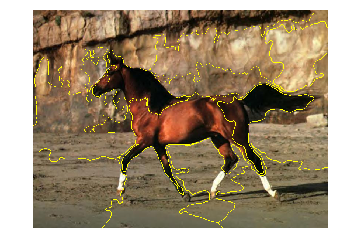

In [2]:
#CODE for SLIC superpixel extraction and mark boundaries. 
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
#Importing packages for interactive widgets
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

# loop over the number of segments
def slic_demo(numSegments):
    # load the image and convert it to a floating point data type
    image = img_as_float(io.imread("horse/rgb/horse001.jpg"))
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
     # show the plots
    plt.show()
slider = widgets.IntSlider(min=10, max=500, step=50, value=15)
widgets.interactive(slic_demo,numSegments=slider)

As we can see from each of these regions edge detection is done very efficiently. However given the difficulty of the problem it would be important to keep the right size for the regions since if they are too little they may be hard to classify when similar colors appear in the background. 

### The labeling: 
The labeling to train the model, will be provided by ground truth images. An ilustration of this can be obtain by the following code: 

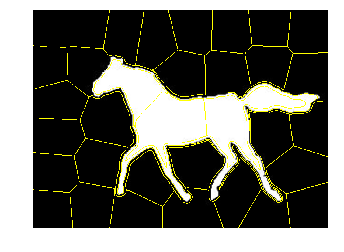

In [200]:
# This code ilustrates the labeling
import cv2 as cv 
from skimage.measure import regionprops
img= cv.imread("horse/figure_ground/horse001.jpg")
img = cv.resize(img,(800,590))
image_1 = img_as_float(img)
segments = slic(image_1, n_segments = numSegments, sigma = 5)
%matplotlib inline
numSegments = 50
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image_1, segments))
plt.axis("off")
plt.show()

Now  we want to access each of these regions separately to extract the descriptors but limited by the region. To do so, we used the mask that we get from the SLIC, and perform the first order statistics calculations for gathering. This process might take several minutes and even hours, so we write into a file the dataset extracted for future usage. If you already ran this, just make sure to keep the text file available and skip this snnipet of code. 

In [ ]:
# This code has all the predefined functions. 
# Importing packages:
from skimage.segmentation import slic,mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import regionprops
from skimage.color import rgb2hsv
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,KFold,ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
import cv2 as cv 
import os,glob, shutil
import numpy as np
import matplotlib.pyplot as plt
def preprocessing(imagename, labeling,n_segments,sigma):
    # load the image and convert it to a floating point data type
    image= img_as_float(io.imread(imagename))
    #load the image with the labeling
    imlabels= cv.imread(labeling)
    imlabels= cv.resize(imlabels,(image.shape[1],image.shape[0]))
    # Perform slic super pixels segmentations
    segments = slic(image, n_segments = n_segments, sigma = sigma)
    regionpro=regionprops(segments,imlabels[:,:,1])
    prob=np.array([p.mean_intensity/255 for p in regionpro])
    prob = np.insert(prob, 0, [0])
    labels=[0 if i<0.5 else 1 for i in prob]
    return image,segments,labels

def make3d(descriptor):
    if (descriptor.ndim==2):
        dim=1
    else:
        dim=descriptor.shape[2]
    return np.reshape(descriptor, (descriptor.shape[0],descriptor.shape[1],dim))


def compute_polling(plane, segments):
    numsegments = int(np.max(segments)+1)
    fv = np.zeros((5,numsegments))
    fv[3,:] = np.max(plane)
    fv[4,:] = np.min(plane)
    for y in range(plane.shape[0]):
        for x in range(plane.shape[1]):
            L = int(segments[y,x])
            V = plane[y,x]
            fv[0,L] = fv[0,L]+1
            fv[1,L] = fv[1,L]+V
            fv[2,L] = fv[2,L]+V**2
            fv[3,L] = min(fv[3,L],V)
            fv[4,L] = max(fv[4,L],V)
    #for L in range(numsegments):
    fv[1,:] = fv[1,:]/fv[0,:]
    fv[2,:] = fv[2,:]-fv[1,:]**2
    fv[np.isnan(fv)] = 0
    return fv


def build_features(image, segments):
    hsv = rgb2hsv(image)
    h=hsv[:,:,0]/180
    s=hsv[:,:,1]/255
    v=hsv[:,:,2]/255
    ga=cv.GaussianBlur(image,(61,61),8.0)
    laga=cv.Laplacian(ga,cv.CV_64F)
    sobel= cv.Sobel(image,cv.CV_64F,1,0,ksize=3)
    descriptors=[image,h,s,v,ga,laga,sobel]  
    dataset=np.zeros((5,segments.max()+1))
    count=0
    for descriptor in descriptors:
        descriptor = make3d(descriptor)
        for channel in range(0,descriptor.shape[2]):
            plane = descriptor[:,:,channel]
            fv=compute_polling(plane,segments)
            dataset=np.r_[dataset,fv]
    return dataset

def build_dataset(imagespath,labelingpath,n_segments,sigma):
    imlist = glob.glob(os.path.join(imagespath,'*.jpg'))
    data  = np.ndarray((0,80))
    labeling = []
    for im in imlist[0:20]:
        image,segments,labels = preprocessing(im,labelingpath+im[10:],n_segments,sigma)
        dataset = np.transpose(build_features(image,segments))
        data = np.r_[data,dataset]
        labeling += labels
    return data,labeling

def classify(dataset,labels,classifier):
    k = 5
    n_splits=5
    skf = StratifiedKFold(n_splits=n_splits)
    skf_ss = StratifiedShuffleSplit(n_splits=n_splits)
    C=1
    classifiers={"knn":KNeighborsClassifier(n_neighbors=k),"svml":svm.SVC(kernel='linear', C=C)
                 ,"svmr":svm.SVC(kernel='rbf', C=C),
                   "boost":GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                                             max_depth=2, random_state=0)}
    scores={}
    for k in classifier:
        sc = cross_val_score(classifiers[k],dataset,labels,cv=skf)
        sc_f = cross_val_score(classifiers[k],dataset,labels,cv=skf,scoring ='f1')
        sc2 = cross_val_score(classifiers[k],dataset,labels,cv=skf_ss)
        sc2_f = cross_val_score(classifiers[k],dataset,labels,cv=skf_ss,scoring ='f1')
        scores[k] = [sc.mean(),sc.std()]
        scores["shuffling "+ k]=[sc2.mean(),sc2.std()]
        scores["f1 "+ k]=[sc_f.mean(),sc_f.std()]
        scores["Shuffling-f1 "+ k]=[sc2_f.mean(),sc2_f.std()]
    return scores

### Example: 

In this following example we present supervised approach over 21 examples, mostly for running time purposes and illustration.

There are 4 classifiers available : knn, Boosting, SVM rbf and SVM linear. However in the following example we only include knn and boost. 

For scoring we use acuracy and f1-score  cross validation.

In [4]:
imagespath = "horse/rgb/"
labelingpath = "horse/figure_ground/"
data,labels = build_dataset(imagespath,labelingpath,50,5)


In [5]:
classify(data,labels,["knn","boost"])

{'Shuffling-f1 boost': [0.76581308571267659, 0.048313560608053266],
 'Shuffling-f1 knn': [0.46277452819777071, 0.085966636056389253],
 'boost': [0.79824528372662074, 0.061792230306419893],
 'f1 boost': [0.62700728229560454, 0.10405099208139065],
 'f1 knn': [0.3428186960632571, 0.055746817202205333],
 'knn': [0.72037324780849832, 0.043963844673399782],
 'shuffling boost': [0.85842696629213489, 0.027152912300212523],
 'shuffling knn': [0.78426966292134837, 0.033632875386732056]}

We can observe the boosting strategy, with f1 score, come closer to the results presented by  [4], using a similar set-up. 

The following function runs for the whole dataset  and will create a full dataset saved on a text file. 

In [ ]:
# Function to extract features for the whole dataset. Takes long time, 
#so once it is done you can just load the text files. 
def main():
    imagespath = "horse/rgb/"
    labelingpath = "horse/figure_ground/"
    data,labels = build_dataset(imagespath,labelingpath,50,5)
    np.savetxt("data1.txt", data)
    np.savetxt("labels1.txt",labels)
    #results=classify(data,labels,["knn","boost"])
    #np.savetxt("results1.txt",results)
main()

## Active Learning: 

Active Learning  strategy aim to reduce the ammount of labeled data, by selecting cleverly this data and ask an expert for the annotation. In this case we will use the ground truth, for simulate the annotation of an expert. 

The function regionprops can extract the properties of certain region for classification purposes. With this we can see how the labeling is going to work. We are basically trying to automatize the labeling of the "easy" regions such as white or black regions, while the "hard" ones will be asked to an expert and are represented in gray. 

The following code illustrates how the ground truth works in order to assign a label to each of the regions, to simulate the annotation. The gray color would indicate that the classifier is not quite sure of the label and therefore will need to ask and expert for it.

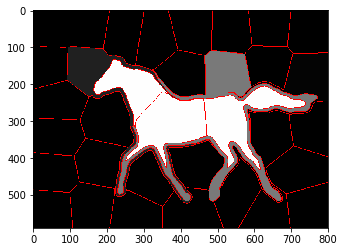

In [201]:
# Region properties and probability normalization
import numpy as np
regionpro=regionprops(segments,img[:,:,1])
prob=np.array([p.mean_intensity/255 for p in regionpro])
#prob = np.append(prob, [0.5,0.5,0.5])
prob = np.insert(prob, 0, [0])
labels=[0 if i<0.5 else 1 for i in prob]
a=prob[segments]
a.reshape((590, 800, 1));
plt.imshow(mark_boundaries(np.dstack((a,a,a)), segments, color=(1,0,0)));

In [155]:
# Libact Example. 
import copy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import SklearnAdapter
from libact.models import *
from libact.query_strategies import *
from libact.labelers import IdealLabeler


def run(trn_ds, tst_ds, lbr, model, qs, quota,fully_labeled_trn_ds):
    E_in, E_out,E_full = [], [],[]

    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        
        E_in = np.append(E_in, 1 - model.score(trn_ds))
        E_out = np.append(E_out, 1 - model.score(tst_ds))
        E_full= np.append(E_full, 1-model.score(fully_labeled_trn_ds))
        
    return E_in, E_out,E_full


def split_train_test(X,y, test_size, n_labeled):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train0, _, y_train0, _ = train_test_split(X_train, y_train, train_size=n_labeled, stratify=y_train)
    #trn_ds = Dataset(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    trn_ds = Dataset(X_train,np.concatenate([y_train0,[None]*(len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds
def active_learning(data,labels,test_size,n_labeled):
    # Load dataset
    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = split_train_test(data,labels, test_size, n_labeled)
    trn_ds2 = copy.deepcopy(trn_ds)
    lbr = IdealLabeler(fully_labeled_trn_ds)

    quota = len(y_train) - n_labeled    # number of samples to query

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
    clf=SklearnProbaAdapter(GradientBoostingClassifier(n_estimators=5, learning_rate=1.0,max_depth=2, random_state=0))
    qs = UncertaintySampling(trn_ds, method='lc', model=clf)
    model = clf
    E_in_1, E_out_1,E_full_1 = run(trn_ds, tst_ds, lbr, model, qs, quota,fully_labeled_trn_ds)

    qs2 = RandomSampling(trn_ds2)
    model = clf
    E_in_2, E_out_2, E_full_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota,fully_labeled_trn_ds)

    # Plot the learning curve of UncertaintySampling to RandomSampling
    # The x-axis is the number of queries, and the y-axis is the corresponding
    # error rate.
    rows=["E_in_1","E_in_2", "E_out_1", "E_out_2","E_full_1","E_full_2"]
    data=pd.DataFrame(data=[E_in_1, E_in_2, E_out_1, E_out_2,E_full_1,E_full_2],index=rows)
    return data

def plotting(data,colors=['darkblue','orange','b','r','lightblue','pink']):
    query_num = np.arange(1, len(E_in_1)+1)
    keys=data.keys()
    for k in range(0,len(keys),2):
        plt.plot(query_num, data[keys[k]], color=colors[k], label='qs '+ keys[k][:-2])
        plt.plot(query_num, data[keys[k+1]], color=colors[k+1], label='random '+ keys[k+1][:-2])
    
    plt.xlabel('Number of Queries')
    plt.ylabel('Error')
    plt.title('Experiment Result')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
    plt.show()
    
def AL(data,labels,test_size,n_label,num_experiments):
    experiments={}
    for i in range(num_experiments):
        result=active_learning(data,labels,test_size,n_labeled)
        experiments["Experiment" +str(i)]=result    
    return pd.Panel(experiments)
    

### Example 2: 

Following the example 1, we used active learning for classification. The first graph will illustrate the result after just one repetition which could be very noisy, but provide us an idea of what is the behaviour of the classifier. While the second one, will give us more insight on the final performance of the random sampling approach and Uncertainty sampling approach.

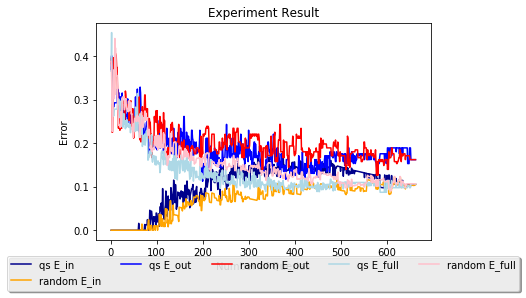

In [193]:
# Just one iteration example over the data: Less smooth curve. 
test_size = 0.25 # the percentage of samples in the dataset that will be                  # randomly selected and assigned to the test set
n_labeled = 2 # number of samples that are initially labeled
experiment = active_learning(data,labels,test_size,n_labeled)
plotting(experiment.transpose())

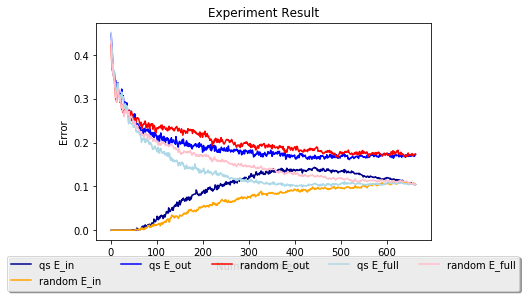

In [192]:
#  #iterations defined by the user to achieve more smooth curves
iterations =20
test_size = 0.25 # the percentage of samples in the dataset that will be                  # randomly selected and assigned to the test set
n_labeled = 2 # number of samples that are initially labeled
panel=AL(data,labels,test_size,n_labeled,iterations)
master_panel=panel.mean(axis=0)
plotting(master_panel.transpose())

### Discussion: 

In the previous example we used Gradient Boosting, with 5 estimators to prevent overfitting. Also we tried to be as close as possible to [4], therefore we used a learning rate of 1 and max depth of 2. 

We can observe a slightly better performance using Uncertainty sampling as query strategy. However the difference is not very significantly. Both of them normalize around 20% of error testing outside of the training split. As for the inside and the full dataset, we see a tendency to over 10% when the whole dataset is being used. This is due to the complexity of the problem. Since there are patches similar in color and shape, combining the background and the body of the horse, it is hard to describe precisely each region to conduct high accuracy classification. 

In the following section we will plot some scatter plots that would provide some more insight 
in the type of problem we are facing.

## Whole Dataset 

We have previously run the descriptors extraction for the whole dataset, and you can find it in the "data.txt" and "labels.txt" files. In case you don't have it, you can go upper in this notebook you can run it again, it is under "# Function to extract features for the whole dataset. Takes long time" title. 


In [ ]:
data=np.loadtxt("data.txt")
labels=np.loadtxt("labels.txt")
test_size = 0.25 # the percentage of samples in the dataset that will be                  # randomly selected and assigned to the test set
n_labeled = 4 # number of samples that are initially labeled

### Testing and Characterization: 

With this information we can run some charaterization on the data, that would lead us to understand better the problem and it's possibilites.

0.24214955189163304

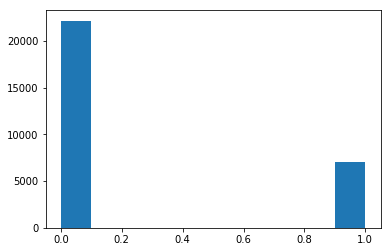

In [220]:
plt.hist(labels)
np.sum(labels==1)/len(labels)

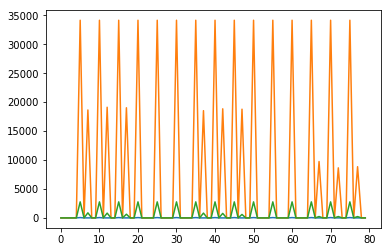

In [221]:
N=data.shape[1]
_r=range
plt.plot(_r(N),data[:,_r(N)].min(0),_r(N),data[:,_r(N)].max(0),_r(N),data[:,_r(N)].mean(0))

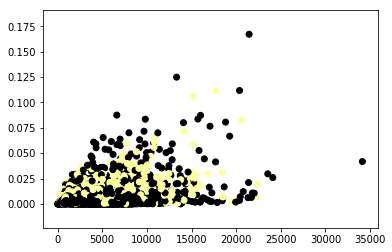

In [222]:
plt.scatter(data[:,5],data[:,62], c=labels, cmap='inferno')

In [223]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
logistic = LogisticRegression()
logistic.fit(data, labels)
data4 = logistic.predict(data)


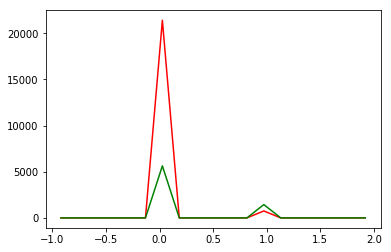

In [225]:
def view_class_hist(data, labels, bins=10):
    h0,b0=np.histogram(data[labels==0],bins=bins,normed=False)
    h1,b1=np.histogram(data[labels==1],bins=bins,normed=False)
    plt.plot(0.5*(b0[0:-1]+b0[1:]),h0,'r', 0.5*(b1[0:-1]+b1[1:]),h1, 'g')
view_class_hist(data4, labels, np.linspace(-1,2,20))

In [ ]:
experiment = active_learning(data,labels,test_size,n_labeled)


In [ ]:
plotting(experiment.transpose())

In [110]:
%matplotlib inline

# References: 

[1] Y.-Y. Yang, S.-C. Lee, Y.-A. Chung, T.-E. Wu, H.-T. Lin. 2015. library:libact. Available at: http://libact.readthedocs.io/

[2] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) http://dx.doi.org/10.7717/peerj.453

[3] https://avaminzhang.wordpress.com/2012/12/07/%E3%80%90dataset%E3%80%91weizmann-horses/

[4] K. Konyushkova and R. Sznitman and P. Fua, Introducing Geometry in Active Learning for Image Segmentation,CoRR, abs/1508.04955, 2015,http://arxiv.org/abs/1508.04955. 

[5] Achanta, R., Shaji, A., Smith, K., Lucchi, A., Fua, P., & Süsstrunk, S. (2010). Slic superpixels (No. EPFL-REPORT-149300).

[6] Adrian Rosebrock: http://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/